# Speech Denoising #

white : additive_gaussian_noise 
0 : air_conditioner
1 : car_horn 
2 : children_playing 
3 : dog_bark 
4 : drilling 
5 : engine_idling 
6 : gun_shot 
7 : jackhammer 
8 : siren 
9 : street_music 


In [1]:
noise_class = "white" 

#### Noise2Noise" or "Noise2Clean"  ###

In [2]:
training_type =  "Noise2Noise" 

### Import of libraries ###

In [3]:
from pathlib import Path
import os
import sys

sys.path.append(r'utils')
os.chdir(Path.cwd())

In [4]:
if noise_class == "white": 
    TRAIN_INPUT_DIR = Path(r'Datasets/WhiteNoise_Train_Input')

    if training_type == "Noise2Noise":
        TRAIN_TARGET_DIR = Path(r'Datasets\WhiteNoise_Train_Output')
    elif training_type == "Noise2Clean":
        TRAIN_TARGET_DIR = Path(r'Datasets\clean_trainset_28spk_wav')
    else:
        raise Exception("Enter valid training type")

    TEST_NOISY_DIR = Path(r'Datasets\WhiteNoise_Test_Input')
    TEST_CLEAN_DIR = Path(r'Datasets\clean_testset_wav') 
    
else:
    raise Exception("Enter valid noise type")

In [5]:
basepath = str(noise_class)+"_"+training_type
os.makedirs(basepath, exist_ok=True)
os.makedirs(os.path.join(basepath, "Weights"), exist_ok=True)
os.makedirs(os.path.join(basepath, "Samples"), exist_ok=True)

In [6]:
import time
import pickle
import warnings
import gc
import copy

import utils.noise_addition_utils

from utils.metrics import AudioMetrics
from utils.metrics import AudioMetrics2

import numpy as np
import torch
import torch.nn as nn
import torchaudio

from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
from pypesq import pesq
from IPython.display import clear_output, Audio

%matplotlib inline

# not everything is smooth in sklearn, to conveniently output images in colab
# we will ignore warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
np.random.seed(999)
torch.manual_seed(999)

# If running on Cuda set these 2 for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Checking whether the GPU is available ###

In [8]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

No GPU available, training on CPU.


In [9]:
!nvidia-smi

Tue Nov 21 23:44:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.89       Driver Version: 528.89       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A300... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    10W /  80W |    315MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set Audio backend as Soundfile for windows

In [10]:
torchaudio.set_audio_backend("soundfile")
print("TorchAudio backend used:\t{}".format(torchaudio.get_audio_backend()))

TorchAudio backend used:	soundfile


### The sampling frequency and the selected values for the Short-time Fourier transform. ###

In [11]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

### The declaration of datasets and dataloaders ###

In [12]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a Short-tome Fourier transform,
    normalizes and leads to a tensor.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True, return_complex=False)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True, return_complex=False)
        # x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
        #                           hop_length=self.hop_length, normalized=True)
        # x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
        #                           hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

In [13]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

print("No. of Training files:",len(train_input_files))
print("No. of Testing files:",len(test_noisy_files))

No. of Training files: 11660
No. of Testing files: 760


In [14]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_input_files, train_target_files, N_FFT, HOP_LENGTH)

In [15]:
TRAIN_TARGET_DIR

WindowsPath('Datasets/WhiteNoise_Train_Output')

In [16]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)


### Visualize input data

In [264]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

In [271]:
clean_dataset_dir = r'vivos/vivos/train/'

In [272]:
def pie(data, ax, title='Title'):
    def pct(pct_data, data):
        absolute = int(np.round(pct_data/100*np.sum(data)))
        return f'{absolute}'
    ax.pie(data,
           labels=data.keys(),
           autopct=lambda x: pct(x, data),
           )
    ax.set(title=title)

#### Vivos dataset

The VIVOS dataset is a collection of Vietnamese speech data for speech recognition and synthesis tasks. It contains a large number of audio recordings along with their transcriptions and metadata.<br>
VIVOS is a free Vietnamese speech corpus consisting of 15 hours of recording speech prepared for Vietnamese Automatic Speech Recognition task.<br>
The corpus was prepared by AILAB, a computer science lab of VNUHCM - University of Science, with Prof. Vu Hai Quan is the head of. <br>
Cite: Luong, H. T., & Vu, H. Q. (2016, December). A non-expert Kaldi recipe for Vietnamese speech recognition system. In <i>Proceedings of the Third International Workshop on Worldwide Language Service Infrastructure and Second Workshop on Open Infrastructures and Analysis Frameworks for Human Language Technologies (WLSI/OIAF4HLT2016)</i> (pp. 51-55).<br>
|            | Train | Test |
|------------|-------|------|
| Speakers   | 46    | 19   |
| Utterances | 11660 | 760  |
| Duration   | 14:55 | 00:45|
| Unique Syllables | 4617 | 1692 |

In [273]:
file_info = []

for root, dirs, files in os.walk(os.path.join(clean_dataset_dir, 'waves')):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)
            waveform, sample_rate = torchaudio.load(file_path)
            duration = waveform.size(1) / sample_rate
            file_info.append({'File': file, 'Length (s)': duration,'Size (KB)': file_size/1024})

df = pd.DataFrame(file_info)

In [274]:
df.sample(5)

File  Length (s)  Size (KB)
8429   VIVOSSPK34_264.wav        4.50     140.70
589   VIVOSSPK03_R090.wav        3.66     114.30
1548  VIVOSSPK07_R049.wav        5.12     160.20
1479  VIVOSSPK06_T030.wav        4.00     125.04
6272   VIVOSSPK25_063.wav        6.12     191.48

In [275]:
genders = pd.read_csv(os.path.join(clean_dataset_dir,'genders.txt'), sep=' ', header=None)
genders.columns = ['Directory', 'Gender']

tmp = []
with open(os.path.join(clean_dataset_dir,'prompts.txt'), encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        pos = line.find(' ')
        if pos >= 0:
            tmp.append({'Directory': line[:pos], 'Prompt': line[pos+1:-1], 'Length (words)': len(line[pos+1:-1].split())})
prompts = pd.DataFrame(tmp)

In [276]:
prompts

Directory                                             Prompt  \
0      VIVOSSPK01_R001                                          KHÁCH SẠN   
1      VIVOSSPK01_R002  CHỈ BẰNG CÁCH LUÔN NỖ LỰC THÌ CUỐI CÙNG BẠN MỚ...   
2      VIVOSSPK01_R003       TRONG SỐ CÁC QUỐC GIA CÔNG NGHIỆP PHÁT TRIỂN   
3      VIVOSSPK01_R004  ANH ĐÃ NHÌN THẤY TRONG NHỮNG LẢI NHẢI DÔNG DÀI...   
4      VIVOSSPK01_R005          KHỦNG HOẢNG MÔI TRƯỜNG CẦN ĐƯỢC NGĂN CHẶN   
...                ...                                                ...   
11655   VIVOSSPK46_296  GIỐNG NHƯ NGHĨA CHÚ BÉ BÌNH ĂN NGỦ CÙNG THẾ GI...   
11656   VIVOSSPK46_297  TIẾP TỤC CHẤM MỘT ÍT NƯỚC BÓNG LÊN PHẦN GIỮA C...   
11657   VIVOSSPK46_298  NHỮNG LẦN ĐÓ CON TỦI THÂN TẠI SAO BA MẸ LẠI LẠ...   
11658   VIVOSSPK46_299  TRONG NHỮNG NĂM ĐẦU TIÊN CHẮC CHẮN NĂNG SUẤT L...   
11659   VIVOSSPK46_300  MỘT SỐ KHÁC TỚI HỎI THỦ TỤC SAU ĐÓ RA VỀ VÀ CH...   

       Length (words)  
0                   2  
1                  14  
2                   9  
3                  12  
4                   8  
...               ...  
11655              13  
11656              15  
11657              15  
11658              13  
11659              15  

[11660 rows x 3 columns]

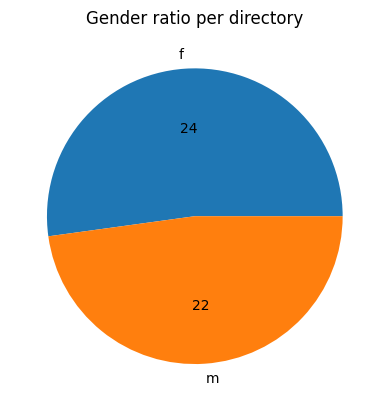

In [279]:
ax = plt.subplot()
pie(genders.Gender.value_counts(),ax, 'Gender ratio per directory')
plt.show()

The data is not gender-biased.

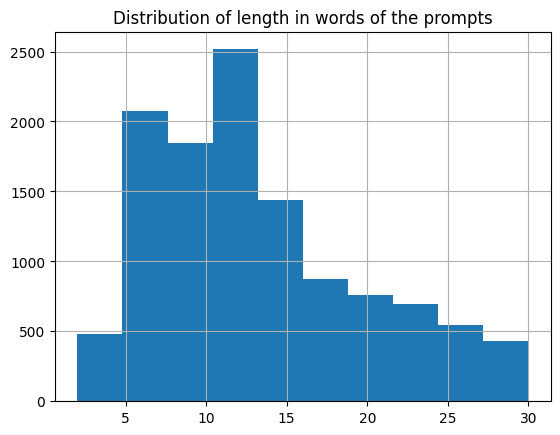

In [280]:
ax = plt.subplot()
prompts['Length (words)'].hist(bins=10, ax=ax)
ax.set_title('Distribution of length in words of the prompts')
plt.show()

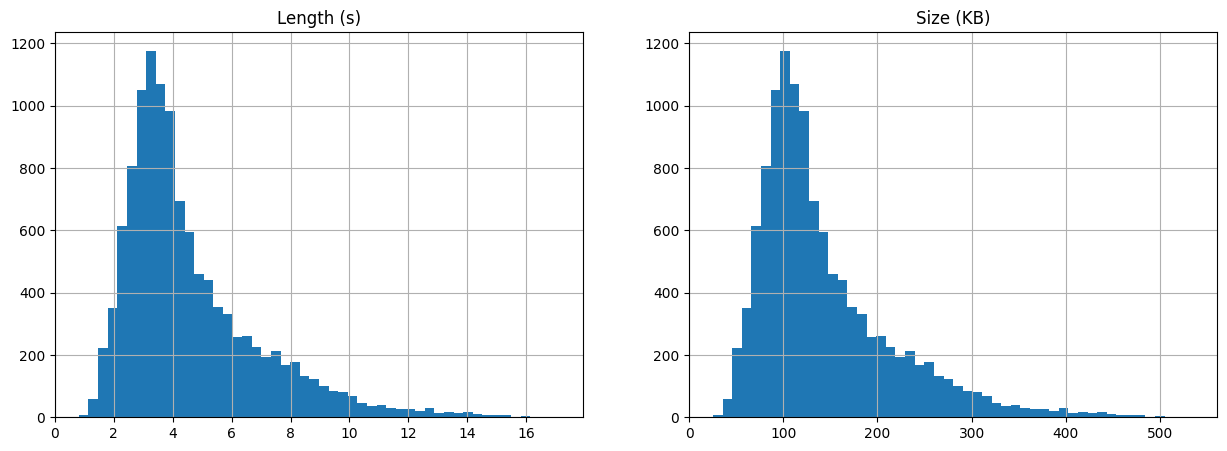

In [281]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

for i, col in enumerate(df.columns[-2:]):
    df[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

### Generated data

In [278]:
for i, (x, y) in enumerate(zip(train_dataset.noisy_files[:3], train_dataset.clean_files[:3])):
    print(i)
    print(x)
    display(Audio(x))
    print(y)
    display(Audio(y))

0
Datasets\WhiteNoise_Train_Input\VIVOSSPK01_R001.wav


Datasets\WhiteNoise_Train_Output\VIVOSSPK01_R001.wav


1
Datasets\WhiteNoise_Train_Input\VIVOSSPK01_R002.wav


Datasets\WhiteNoise_Train_Output\VIVOSSPK01_R002.wav


2
Datasets\WhiteNoise_Train_Input\VIVOSSPK01_R003.wav


Datasets\WhiteNoise_Train_Output\VIVOSSPK01_R003.wav


In [284]:
def plot_waveform(file, ax, col, title):
    waveform, sample_rate = torchaudio.load(file)
    display(Audio(file))
    # Calculate the time values
    num_samples = waveform.size(1)
    length = num_samples / sample_rate
    time_values = np.linspace(0, length, num_samples)
    x_stft = torch.stft(waveform, n_fft=N_FFT, hop_length=HOP_LENGTH, return_complex=True)
    amplitude = torch.abs(x_stft.squeeze())
    amplitude = torch.log(amplitude).numpy()

    ax[0, col].plot(time_values, waveform.t().numpy())
    ax[0, col].set_title(title)
    ax[0, col].set_xlabel('Time (s)')
    ax[0, col].set_ylabel('Amplitude')

    ax[1, col].imshow(amplitude, aspect='auto', origin='lower', extent=[0, waveform.shape[1]/sample_rate, 0, sample_rate])
    ax[1, col].set_title(f'Spectrogram - {title}')
    ax[1, col].set_xlabel('Time')
    ax[1, col].set_ylabel('Frequency')
    ax[1, col].set_ylim(0, 15000)

def get_clean_data_path(file):
    file_name = file.stem
    pos = file_name.find('_')
    dir = file_name[:pos]
    return Path(os.path.join(r'vivos/vivos/train/waves/', dir, file_name+".wav"))

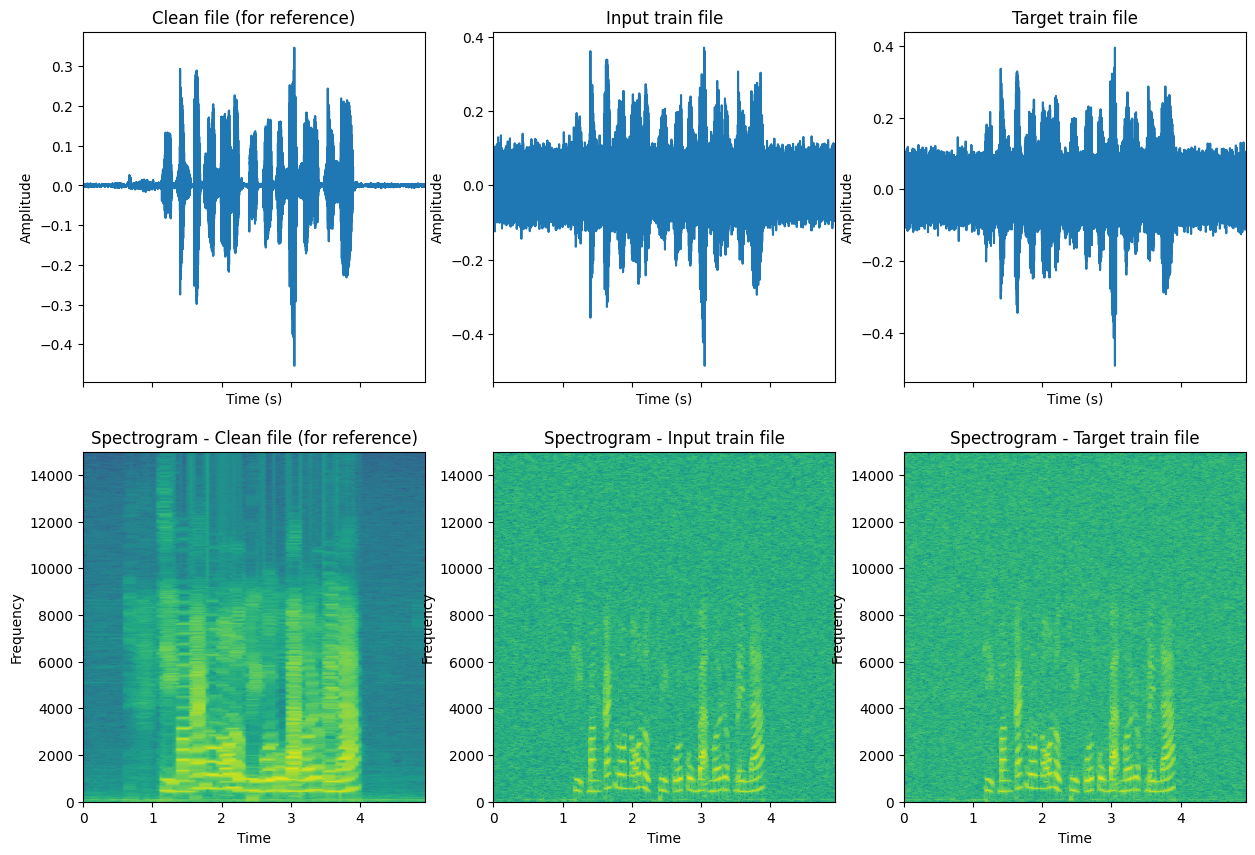

In [285]:
index = 1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharex=True)
plot_waveform(get_clean_data_path(train_input_files[index]), ax, 0, 'Clean file (for reference)')
plot_waveform(train_input_files[index], ax, 1, 'Input train file')
plot_waveform(train_target_files[index], ax, 2, 'Target train file')

plt.show()

- Before noise was added, we can observe each word in the waveform and in the spectrogram with high clarity.
- After WHITE noise was added, the amplitude fluctuates more rigorously, which can be observed in both waveform plot and spectrogram.

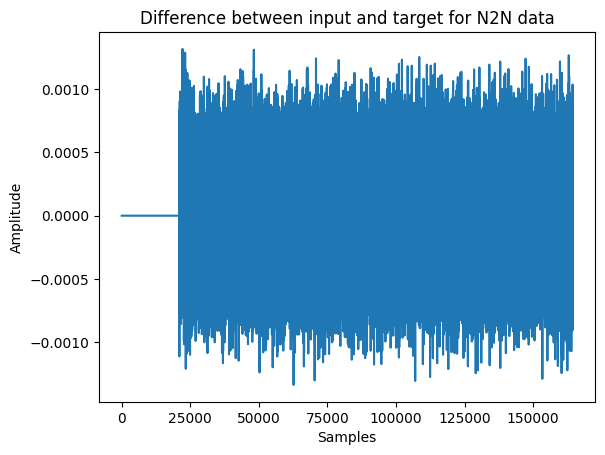

In [288]:
x1, x2 = train_dataset[0]
plt.plot(torch.istft(x1 - x2, N_FFT, hop_length=HOP_LENGTH)[0])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Difference between input and target for N2N data')
plt.show()

For Noise2Noise, the generated noise between input and target files do not differ too much, which resembles the actual WHITE noise in practical scenarios.

### Average Test Set Metrics ###

In [33]:
def test_set_metrics(test_loader, model):
    metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI"]
    overall_metrics = [[] for i in range(len(metric_names))]
    
    for i,(noisy,clean) in enumerate(test_loader):
        x_est = model(noisy.to(DEVICE), is_istft=True)
        x_est_np = x_est[0].view(-1).detach().cpu().numpy()
        clean_np_complex = torch.view_as_complex(torch.squeeze(clean[0], 1))
        x_c_np = torch.istft(torch.squeeze(clean[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
        metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
        
        overall_metrics[0].append(metrics.CSIG)
        overall_metrics[1].append(metrics.CBAK)
        overall_metrics[2].append(metrics.COVL)
        overall_metrics[3].append(metrics.PESQ)
        overall_metrics[4].append(metrics.SSNR)
        overall_metrics[5].append(metrics.STOI)
    
    metrics_dict = dict()
    for i in range(len(metric_names)):
        metrics_dict[metric_names[i]] ={'mean': np.mean(overall_metrics[i]), 'std_dev': np.std(overall_metrics[i])} 
    
    return metrics_dict

### Declaring the class layers ###

In [34]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        
        x_real = x[..., 0]
        x_im = x[..., 1]
        # print ("------xreal")
        # print(type(x_real))
        # print(type(x_im))
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        #c_real = torch.subtract((self.real_conv(x_real)),  (self.im_conv(x_im)))
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        #c_im = torch.add(self.im_conv(x_real) , self.real_conv(x_im))
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [35]:
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        #ct_real = torch.subtract(self.real_convt(x_real) , self.im_convt(x_im))
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        #ct_im = torch.add(self.im_convt(x_real) , self.real_convt(x_im))
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [36]:
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [37]:
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [38]:
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

### Loss function ###

In [39]:
from pesq import pesq
from scipy import interpolate

def resample(original, old_rate, new_rate):
    if old_rate != new_rate:
        duration = original.shape[0] / old_rate
        time_old  = np.linspace(0, duration, original.shape[0])
        time_new  = np.linspace(0, duration, int(original.shape[0] * new_rate / old_rate))
        interpolator = interpolate.interp1d(time_old, original.T)
        new_audio = interpolator(time_new).T
        return new_audio
    else:
        return original


def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    y_true_ = torch.view_as_complex(y_true_)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False)
    x_ = torch.squeeze(x_, 1)
    x_ = torch.view_as_complex(x_)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

wonky_samples = []

def getMetricsonLoader(loader, net, use_net=True):
    net.eval()
    # Original test metrics
    scale_factor = 32768
    # metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI","SNR "]
    metric_names = ["PESQ-WB","PESQ-NB","SNR","SSNR","STOI"]
    overall_metrics = [[] for i in range(5)]
    for i, data in enumerate(loader):
        if (i+1)%10==0:
            end_str = "\n"
        else:
            end_str = ","
        #print(i,end=end_str)
        if i in wonky_samples:
            print("Something's up with this sample. Passing...")
        else:
            noisy = data[0]
            clean = data[1]
            if use_net: # Forward of net returns the istft version
                x_est = net(noisy.to(DEVICE), is_istft=True)
                x_est_np = x_est.view(-1).detach().cpu().numpy()
            else:
                noisy_complex = torch.view_as_complex(torch.squeeze(noisy, 1))
                #x_est_np = torch.istft(torch.squeeze(noisy, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
                x_est_np = torch.istft(noisy_complex, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
            clean_complex = torch.view_as_complex(torch.squeeze(clean, 1))
            #x_clean_np = torch.istft(torch.squeeze(clean, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
            x_clean_np = torch.istft(clean_complex, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
            
        
            metrics = AudioMetrics2(x_clean_np, x_est_np, 48000)
            
            ref_wb = resample(x_clean_np, 48000, 16000)
            deg_wb = resample(x_est_np, 48000, 16000)
            pesq_wb = pesq(16000, ref_wb, deg_wb, 'wb')
            
            ref_nb = resample(x_clean_np, 48000, 8000)
            deg_nb = resample(x_est_np, 48000, 8000)
            pesq_nb = pesq(8000, ref_nb, deg_nb, 'nb')

            #print(new_scores)
            #print(metrics.PESQ, metrics.STOI)

            overall_metrics[0].append(pesq_wb)
            overall_metrics[1].append(pesq_nb)
            overall_metrics[2].append(metrics.SNR)
            overall_metrics[3].append(metrics.SSNR)
            overall_metrics[4].append(metrics.STOI)
    print()
    print("Sample metrics computed")
    results = {}
    for i in range(5):
        temp = {}
        temp["Mean"] =  np.mean(overall_metrics[i])
        temp["STD"]  =  np.std(overall_metrics[i])
        temp["Min"]  =  min(overall_metrics[i])
        temp["Max"]  =  max(overall_metrics[i])
        results[metric_names[i]] = temp
    print("Averages computed")
    if use_net:
        addon = "(cleaned by model)"
    else:
        addon = "(pre denoising)"
    print("Metrics on test data",addon)
    for i in range(5):
        print("{} : {:.3f}+/-{:.3f}".format(metric_names[i], np.mean(overall_metrics[i]), np.std(overall_metrics[i])))
    return results

### Description of the training of epochs. ###

In [40]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

### Description of the validation of epochs ###

In [41]:
def test_epoch(net, test_loader, loss_fn, use_net=True):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        # Calc the metrics here
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter
    
    
    #print("Actual compute done...testing now")
    
    testmet = getMetricsonLoader(test_loader,net,use_net)

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss, testmet

### To understand whether the network is being trained or not, we will output a train and test loss. ###

In [42]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        
        if e == 0 and training_type=="Noise2Clean":
            print("Pre-training evaluation")
            with torch.no_grad():
               test_loss,testmet = test_epoch(net, test_loader, loss_fn,use_net=False)
            print("Had to load model.. checking if deets match")
            testmet = getMetricsonLoader(test_loader,net,False)    # again, modified cuz im loading
            test_losses.append(test_loss)
            print("Loss before training:{:.6f}".format(test_loss))
        
            with open(basepath + "/results.txt","w+") as f:
                f.write("Initial : \n")
                f.write(str(testmet))
                f.write("\n")
        
        
        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        test_loss = 0
        scheduler.step()
        print("Saving model....")
        
        with torch.no_grad():
            test_loss, testmet = test_epoch(net, test_loader, loss_fn,use_net=True)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #print("skipping testing cuz peak autism idk")
        
        with open(basepath + "/results.txt","a") as f:
            f.write("Epoch :"+str(e+1) + "\n" + str(testmet))
            f.write("\n")
        
        print("OPed to txt")
        
        torch.save(net.state_dict(), basepath +'/Weights/dc20_model_'+str(e+1)+'.pth')
        torch.save(optimizer.state_dict(), basepath+'/Weights/dc20_opt_'+str(e+1)+'.pth')
        
        print("Models saved")

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_loss, test_loss

In [43]:
basepath

'white_Noise2Noise'

### 20 Layer DCUNet Model ###

In [44]:
class DCUnet20(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)
        self.encoders = []
        self.model_length = 20 // 2
        
        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             filter_size=self.enc_kernel_sizes[i], stride_size=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i])
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)
       
        
    def forward(self, x, is_istft=True):
        # print('x : ', x.shape)
        orig_x = x
        xs = []
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
            # print('Encoder : ', x.shape)
            
        p = x
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            # print('Decoder : ', p.shape)
            p = torch.cat([p, xs[self.model_length - 1 - i]], dim=1)
        
        # u9 - the mask
        
        mask = p
        
        # print('mask : ', mask.shape)
        
        output = mask * orig_x
        output = torch.squeeze(output, 1)


        if is_istft:
            #
            output = torch.view_as_complex(output)
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True, return_complex=False)
        
        return output

    
    def set_size(self, model_complexity, model_depth=20, input_channels=1):

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3), 
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))

## Training New Model ##

In [45]:
# # clear cache
gc.collect()
torch.cuda.empty_cache()

dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())
loss_fn = wsdr_fn
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [46]:
from torchsummary import summary
import torchvision.models as models

summary(dcunet20)

TypeError: summary() missing 1 required positional argument: 'input_size'

In [ ]:
# specify paths and uncomment to resume training from a given point
# model_checkpoint = torch.load(path_to_model)
# opt_checkpoint = torch.load(path_to_opt)
# dcunet20.load_state_dict(model_checkpoint)
# optimizer.load_state_dict(opt_checkpoint)

In [ ]:
train_losses, test_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, 4)

## Using pretrained weights to run denoising inference ##

#### Select the model weight .pth file ####

In [47]:
model_weights_path = "Pretrained_Weights/Noise2Noise/white.pth"
# model_weights_path = "white_Noise2Noise/Weights/dc20_model_4.pth"

dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())

checkpoint = torch.load(model_weights_path,
                        map_location=torch.device('cpu')
                       )

#### Select the testing audio folders for inference ####

In [48]:
test_noisy_files = sorted(list(Path(r'Datasets\WhiteNoise_Test_Input').rglob('*.wav')))
test_clean_files = sorted(list(Path(r'Datasets\clean_testset_wav').rglob('*.wav')))

test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [49]:
dcunet20.load_state_dict(checkpoint)

<All keys matched successfully>

#### Enter the index of the file in the Test Set folder to Denoise and evaluate metrics waveforms (Indexing starts from 0) ####

In [50]:
index = 0

In [51]:
dcunet20.eval()
test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

x_n, x_c = next(test_loader_single_unshuffled_iter)
for _ in range(index):
    x_n, x_c = next(test_loader_single_unshuffled_iter)
x_n = x_n.to(DEVICE)  # Move input tensor to GPU
x_est = dcunet20(x_n, is_istft=True)

In [65]:
x_c.shape

torch.Size([1, 1, 1537, 215, 2])

In [66]:
x_n.shape

torch.Size([1, 1, 1537, 215, 2])

In [52]:
x_est_np = x_est[0].view(-1).detach().cpu().numpy()
x_c_complex = torch.view_as_complex(torch.squeeze(x_c[0], 1))
x_n_complex = torch.view_as_complex(torch.squeeze(x_n[0], 1))
#x_c_np = torch.istft(torch.squeeze(x_c[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
#x_n_np = torch.istft(torch.squeeze(x_n[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
x_c_np = torch.istft(x_c_complex, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()
x_n_np = torch.istft(x_n_complex, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,return_complex=False).view(-1).detach().cpu().numpy()

In [68]:
print(x_est.shape, x_est_np.shape)
print(x_c.shape, '-'*10, x_n.shape)
print(x_c_complex.shape, '-'*10, x_n_complex.shape)
print(x_c_np.shape, '-'*10, x_n_np.shape)

torch.Size([1, 164352]) (164352,)
torch.Size([1, 1, 1537, 215, 2]) ---------- torch.Size([1, 1, 1537, 215, 2])
torch.Size([1, 1537, 215]) ---------- torch.Size([1, 1537, 215])
(164352,) ---------- (164352,)


In [64]:
x_est_np.shape

(164352,)

#### Metrics ####

In [69]:
metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
print(metrics.display())

CSIG : 1.000
CBAK : 3.191
COVL : 1.000
PESQ : 2.201
SSNR : 10.752
STOI : 0.850
SNR : 19.196
None


#### Visualization of denoising the audio in /Samples folder ####

#### Noisy audio waveform ####

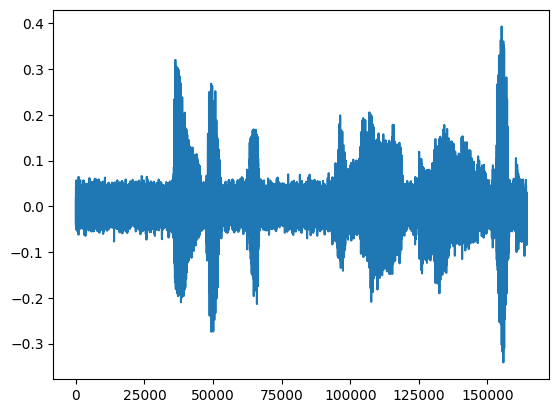

In [70]:
plt.plot(x_n_np)

#### Model denoised audio waveform ####

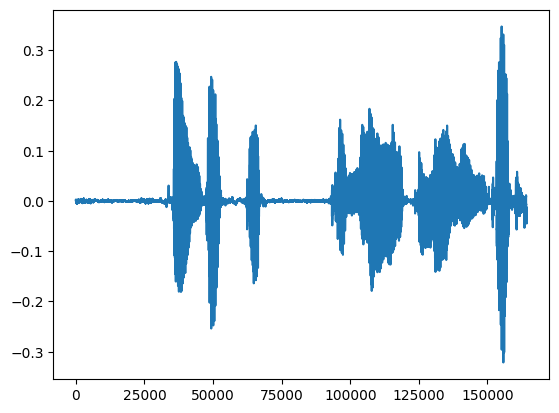

In [71]:
plt.plot(x_est_np)

#### True clean audio waveform ####

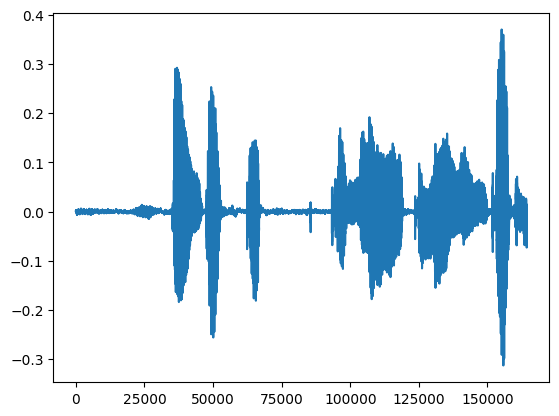

In [72]:
plt.plot(x_c_np)

#### Save Recently Denoised Speech Files ####

In [ ]:
noise_addition_utils.save_audio_file(np_array=x_est_np,file_path=Path("Samples/denoised.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
noise_addition_utils.save_audio_file(np_array=x_c_np,file_path=Path("Samples/clean.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
noise_addition_utils.save_audio_file(np_array=x_n_np,file_path=Path("Samples/noisy.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)